In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving serrano_256.png to serrano_256.png
User uploaded file "serrano_256.png" with length 78426 bytes


In [ ]:
!pip install image-quality


     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 174kB 8.7MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp36-cp36m-linux_x86_64.whl size=233337 sha256=795ab280206873e0d549c4d82f8b15c998abe5122ec749175f6f0c671b434823
  Stored in directory: /root/.cache/pip/wheels/5e/9e/b5/dbb033107407eec2f52b8cd24cf024a4b9ec8b62ea5aee995a
Successfully built libsvm


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image 
from math import floor, ceil
from sklearn.metrics import mean_squared_error 
import math
from skimage.metrics import structural_similarity as ssim
import imquality.brisque as brisque

In [ ]:

#function to downsample 512x512 image to 256x256 image

def shrink(img, size, defined_size): # Change - Issue #1
     result = np.zeros((defined_size, defined_size, 3), dtype=np.uint8) # Change - Issue #2

     scale_factor = int(size/defined_size)   
     for i in range(defined_size):
        for j in range(defined_size):
            temp = np.array([0,0,0])
            for x in range(scale_factor): # Change - Issue #3
                for y in range(scale_factor): # Change - Issue #3    
                    temp += img[i*scale_factor + x, j*scale_factor + y] # Change - Issue #3

            result[i,j] = temp / (scale_factor*scale_factor) # Change          

     return result


   
   

In [ ]:
#converting both images into numpy array
img1 = Image.open("baboon.png")
img2 = Image.open("serrano.png")
pix1 = np.array(img1)
pix2 = np.array(img2)


AttributeError: ignored

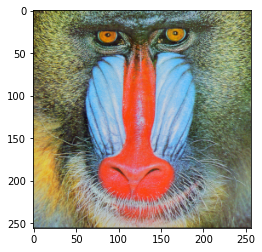

In [ ]:
#downsampling baboon to 256x256
changed_img1 = shrink(pix1, 512, 256) # Change - Issue #1
resized1 = Image.fromarray(changed_img1, 'RGB')
plt.imshow(resized1)


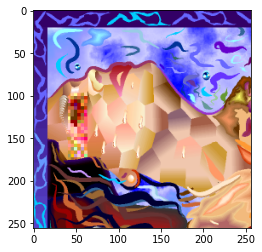

In [ ]:
#downsampling serrano to 256x256
changed_img2 = shrink(pix2, 512, 256) # Change - Issue #1
resized2 = Image.fromarray(changed_img2, 'RGB')
plt.imshow(resized2)

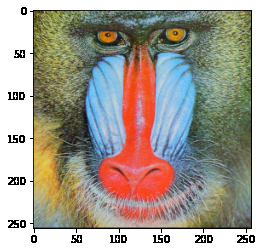

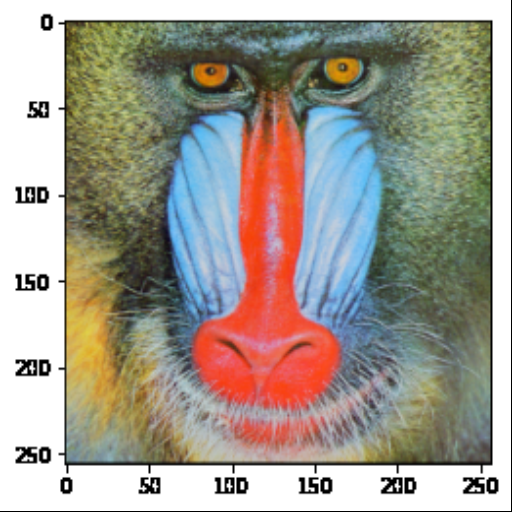

interpolated Baboon (512, 512, 3)


In [80]:
def bilininterpol(src, nw_sz):
    xxxi_w, xxxi_h = nw_sz
    src_h, src_w = src.shape[:2]
    if src_h == xxxi_h and src_w == xxxi_w:
        return src.copy()
    shotsourcex = float(src_w) / xxxi_w
    shotsourcey = float(src_h) / xxxi_h
    
   
    xxxi = np.zeros((xxxi_h, xxxi_w, 3), dtype = np.uint8)
    for n in range(xxxi.shape[2]):
        for xxxi_y in range(xxxi_h):
            for xxxi_x in range(xxxi_w):
               
                sourcex = (xxxi_x + 0.5) * shotsourcex - 0.5 
                sourcey = (xxxi_y + 0.5) * shotsourcey - 0.5
                
                sourcex_0 = int(np.floor(sourcex))
                sourcey_0 = int(np.floor(sourcey))
                sourcex_1 = min(sourcex_0 + 1, src_w - 1)
                sourcey_1 = min(sourcey_0 + 1, src_h - 1)
                
                
                val0 = (sourcex_1 - sourcex) * src[sourcey_0, sourcex_0, n] + (sourcex - sourcex_0) * src[sourcey_0, sourcex_1, n]
                val1 = (sourcex_1 - sourcex) * src[sourcey_1, sourcex_0, n] + (sourcex - sourcex_0) * src[sourcey_1, sourcex_1, n]
                xxxi[xxxi_y, xxxi_x, n] = int((sourcey_1 - sourcey) * val0 + (sourcey - sourcey_0)* val1)
    return xxxi

if __name__ == '__main__':
    img_in1 = cv2.imread('baboon_256.png')
    img_out1 = bilininterpol(img_in1, (512,512))
    cv2_imshow(img_in1)
    cv2_imshow(img_out1)
    print("interpolated Baboon",img_out1.shape)

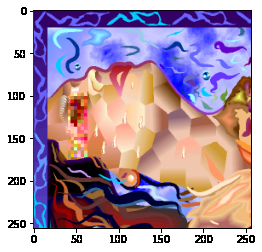

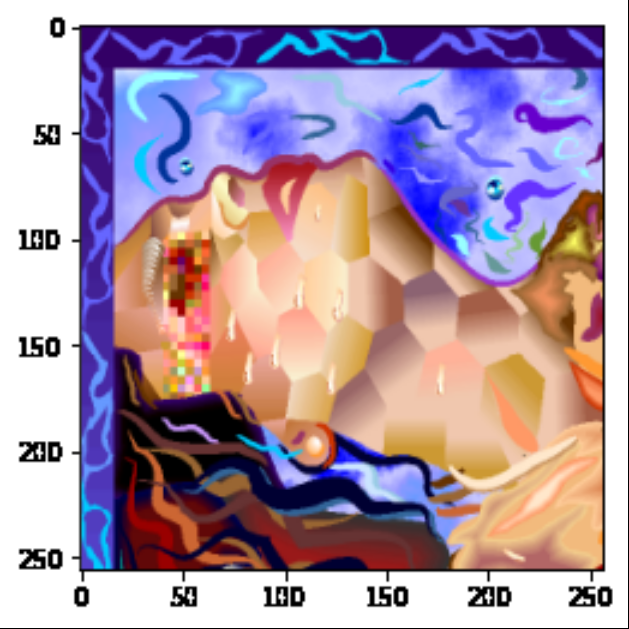

interpolated Serrano (629, 629, 3)


In [79]:
img_in2 = cv2.imread('serrano_256.png')
img_out2 = bilininterpol(img_in2, (629,629))
cv2_imshow(img_in2)
cv2_imshow(img_out2)
print("interpolated Serrano", img_out2.shape)


In [ ]:
#coverting 629*629 image into 794*629

endcolR=[]
endcolB=[]
endcolG=[]
for h in range(629):
  endcolR.append(img_out2[628][h][0])
  endcolB.append(img_out2[628][h][1])
  endcolG.append(img_out2[628][h][2])
coladdition = np.zeros((165,629,3),dtype='uint8')
for f in range(165):
  for g in range(629):
    coladdition[f][q][0]=endcolR[g]
    coladdition[f][q][1]=endcolB[g]
    coladdition[f][q][2]=endcolG[g]
padded_serrano=np.append(img_out2, coladdition, axis=0)






output size after interpolation (794, 629, 3)


In [ ]:
#Filtered images using bilateral ------>
def bfill(image, txtrr, ss, sr):
    r = int(np.ceil(3 * ss))
    
    if image.ndim == 3:
        h, w, ch = image.shape
        I = np.pad(image, ((r, r), (r, r), (0, 0)), 'symmetric').astype(np.float32)
    elif image.ndim == 2:
        h, w = image.shape
        I = np.pad(image, ((r, r), (r, r)), 'symmetric').astype(np.float32)
    else:
        print('Input image is not valid!')
        return image
    
    if txtrr.ndim == 3:
        ht, wt, cht = txtrr.shape
        if ht != h or wt != w:
            
            return image
        T = np.pad(txtrr, ((r, r), (r, r), (0, 0)), 'symmetric').astype(np.int32)
    elif txtrr.ndim == 2:
        ht, wt = txtrr.shape
        if ht != h or wt != w:
            
            return image
        T = np.pad(txtrr, ((r, r), (r, r)), 'symmetric').astype(np.int32)
   
    otpt = np.zeros_like(image)
    SF_s = 1 / (2 * ss * ss)
    SF_r = 1 / (2 * sr * sr)
    
    LXT = np.exp(-np.arange(256) * np.arange(256) * SF_r)
    
    x, y = np.meshgrid(np.arange(2 * r + 1) - r, np.arange(2 * r + 1) - r)
    kerr_s = np.exp(-(x * x + y * y) * SF_s)
    # Main body
    if I.ndim == 2 and T.ndim == 2:     # I1T1 filter
        for y in range(r, r + h):
            for x in range(r, r + w):
                weight = LXT[np.abs(T[y - r:y + r + 1, x - r:x + r + 1] - T[y, x])] * kerr_s
                otpt[y - r, x - r] = np.sum(weight * I[y - r:y + r + 1, x - r:x + r + 1]) / np.sum(weight)
    elif I.ndim == 3 and T.ndim == 2:     
        for y in range(r, r + h):
            for x in range(r, r + w):
                weight = LXT[abs(T[y - r:y + r + 1, x - r:x + r + 1] - T[y, x])] * kerr_s
                wapp_xxt_xxt_xxt = np.sum(weight)
                otpt[y - r, x - r, 0] = np.sum(weight * I[y - r:y + r + 1, x - r:x + r + 1, 0]) / wapp_xxt_xxt_xxt
                otpt[y - r, x - r, 1] = np.sum(weight * I[y - r:y + r + 1, x - r:x + r + 1, 1]) / wapp_xxt_xxt_xxt
                otpt[y - r, x - r, 2] = np.sum(weight * I[y - r:y + r + 1, x - r:x + r + 1, 2]) / wapp_xxt_xxt_xxt
    elif I.ndim == 3 and T.ndim == 3:    
        for y in range(r, r + h):
            for x in range(r, r + w):
                weight = LXT[abs(T[y - r:y + r + 1, x - r:x + r + 1, 0] - T[y, x, 0])] * \
                      LXT[abs(T[y - r:y + r + 1, x - r:x + r + 1, 1] - T[y, x, 1])] * \
                      LXT[abs(T[y - r:y + r + 1, x - r:x + r + 1, 2] - T[y, x, 2])] * \
                      kerr_s
                wapp_xxt_xxt_xxt = np.sum(weight)
                otpt[y - r, x - r, 0] = np.sum(weight * I[y - r:y + r + 1, x - r:x + r + 1, 0]) / wapp_xxt_xxt_xxt
                otpt[y - r, x - r, 1] = np.sum(weight * I[y - r:y + r + 1, x - r:x + r + 1, 1]) / wapp_xxt_xxt_xxt
                otpt[y - r, x - r, 2] = np.sum(weight * I[y - r:y + r + 1, x - r:x + r + 1, 2]) / wapp_xxt_xxt_xxt
    elif I.ndim == 2 and T.ndim == 3:     # I1T3 filter
        for y in range(r, r + h):
            for x in range(r, r + w):
                weight = LXT[abs(T[y - r:y + r + 1, x - r:x + r + 1, 0] - T[y, x, 0])] * \
                      LXT[abs(T[y - r:y + r + 1, x - r:x + r + 1, 1] - T[y, x, 1])] * \
                      LXT[abs(T[y - r:y + r + 1, x - r:x + r + 1, 2] - T[y, x, 2])] * \
                      kerr_s
                otpt[y - r, x - r] = np.sum(weight * I[y - r:y + r + 1, x - r:x + r + 1]) / np.sum(weight)
    else:
        
        return image

    
    return otpt

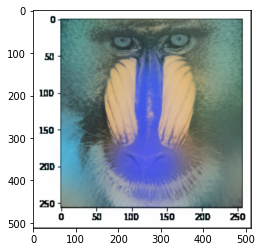

In [ ]:
#Bilinear + Bilateral on Baboon
if __name__ == '__main__':
    ss = 25
    sr = 30
    
    img_gray = cv2.cvtColor(img_out1, cv2.COLOR_BGR2GRAY)
    
    img_bf = bfill(img_out1, img_gray, ss, sr)
    
    plt.imshow(img_bf)

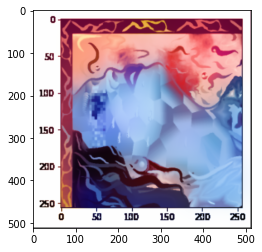

In [ ]:
#Bilinear + Bilateral on Serrano
if __name__ == '__main__':
    ss = 25
    sr = 30
    
    img_grayx = cv2.cvtColor(img_out2, cv2.COLOR_BGR2GRAY)
    
    img_bfx = bfill(img_out2, img_grayx, ss, sr)
    
    plt.imshow(img_bfx)

In [ ]:
#MSE for (i) original Baboon (original img) & interpolated image 

X_true=pix1.flatten()
X_predict_filtered=img_out1.flatten()
xx=mean_squared_error(X_true,X_predict_filtered) 
print(xx)

104.01853815714519


In [ ]:
#MSE for (ii) original Serrano (original img) & interpolated image 

X_true1=pix2.flatten()
X_predict_filtered1=padded_serrano.flatten()
xxx=mean_squared_error(X_true1,X_predict_filtered1) 
print(xxx)

96.09167190601477


In [ ]:
#PSNR for (iii) original Baboon & interpolated

psnr1=20*(math.log10(255/math.sqrt(xx)))
print(str(psnr1) + " dB")

27.95969614820237 dB


In [ ]:
#PSNR for (iv) original Serrano & interpolated

psnr2=20*(math.log10(255/math.sqrt(xxx)))
print(str(psnr2) + " dB")

28.30394611097292 dB


In [ ]:
#SSIM for (v) original Baboon & interpolated 
sxxx=ssim(pix1, img_out1,multichannel=True)
print(sxxx)

0.10585558751816156


In [ ]:
#SSIM for (vi) original Serrano & interpolated 
sxxxx=ssim(pix2, padded_serrano,multichannel=True)
print(sxxxx)

0.16899464140576403


In [ ]:
#Brisque for (vii) interpolated Baboon
bxxx=brisque.score(img_out1)
print(bxxx)

52.407896372785416


In [ ]:
#Brisque for (viii) interpolated serrano
bxxxx=brisque.score(padded_serrano)
print(bxxxx)

76.2086839038868
